
🧠 ANALYSE NREM OPTIMISÉE (Version Granulaire)
Données: 726,500 échantillons (24.2 min)
🔄 Fenêtrage et extraction de features...
  → 500/580 fenêtres
✓ Matrice de features: (580, 44)
✓ PCA: 15 composantes, variance expliquée: 93.41%
✓ UMAP 2D calculé (n_neighbors=5, min_dist=0.0)

🌲 ANALYSE HIÉRARCHIQUE (Dendrogram)


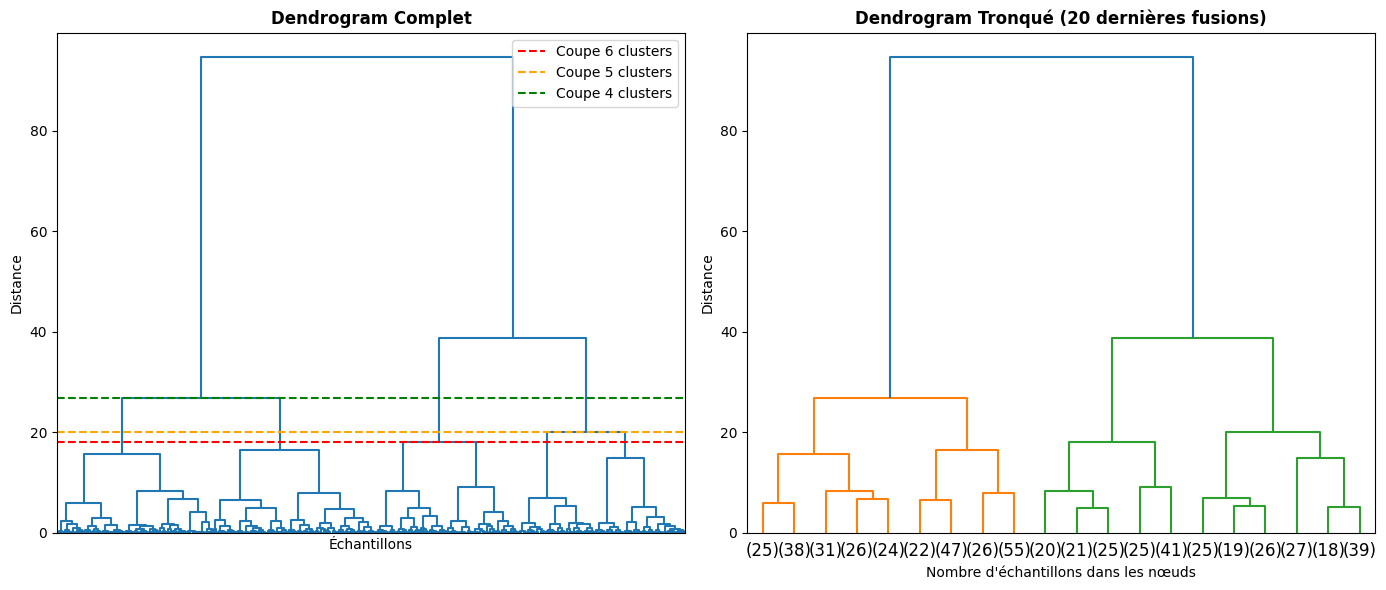


💡 Suggestion d'après le dendrogram: 572 clusters
   (basé sur le plus grand saut de distance)

🔬 TEST AGGLOMERATIVE CLUSTERING (K variable)
K= 2 → Sil=0.548, DB=0.650
K= 3 → Sil=0.447, DB=0.841
K= 4 → Sil=0.402, DB=0.966
K= 5 → Sil=0.385, DB=0.922
K= 6 → Sil=0.402, DB=0.909
K= 7 → Sil=0.397, DB=0.833
K= 8 → Sil=0.410, DB=0.828
K= 9 → Sil=0.437, DB=0.745
K=10 → Sil=0.440, DB=0.701


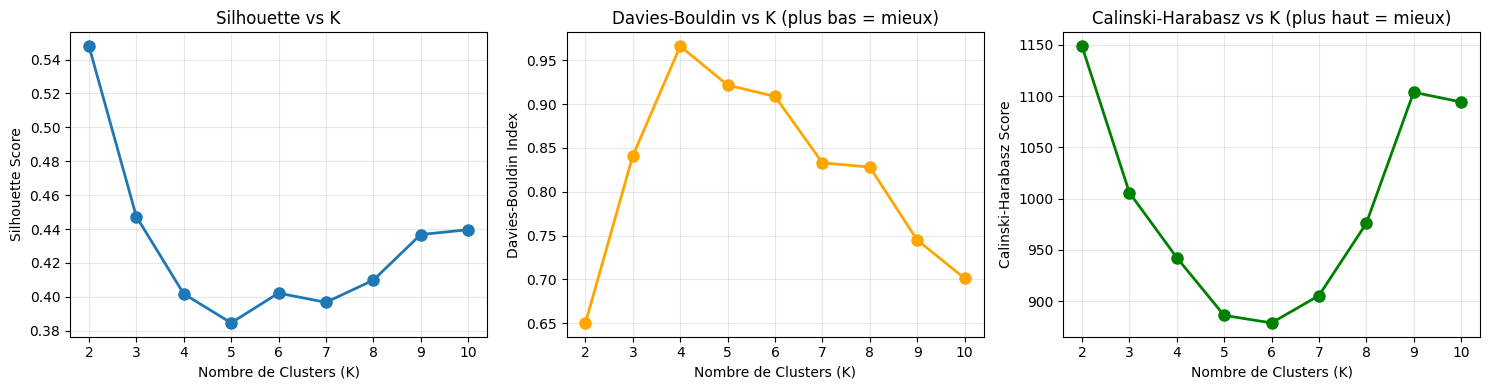


🏆 Meilleur K (Silhouette): 2

🔍 TEST HDBSCAN (Cible: 5 clusters)
min_size= 3, min_samples= 1 → K=102, Bruit=7.6%, Sil=0.579, Score=-9.846
min_size= 3, min_samples= 2 → K=91, Bruit=11.9%, Sil=0.608, Score=-8.676
min_size= 3, min_samples= 3 → K=57, Bruit=14.8%, Sil=0.563, Score=-4.505
min_size= 3, min_samples= 5 → K=38, Bruit=22.1%, Sil=0.599, Score=-2.614
min_size= 3, min_samples= 7 → K=24, Bruit=25.7%, Sil=0.568, Score=-1.182
min_size= 3, min_samples=10 → K=18, Bruit=30.3%, Sil=0.594, Score=-0.662
min_size= 5, min_samples= 1 → K=57, Bruit=7.8%, Sil=0.512, Score=-4.442
min_size= 5, min_samples= 2 → K=52, Bruit=9.1%, Sil=0.505, Score=-3.855
min_size= 5, min_samples= 3 → K=44, Bruit=10.2%, Sil=0.504, Score=-3.080
min_size= 5, min_samples= 5 → K=31, Bruit=16.7%, Sil=0.546, Score=-1.911
min_size= 5, min_samples= 7 → K=21, Bruit=23.4%, Sil=0.556, Score=-0.937
min_size= 5, min_samples=10 → K=17, Bruit=31.0%, Sil=0.600, Score=-0.579
min_size= 7, min_samples= 1 → K=36, Bruit=6.2%, Sil=0.484, S

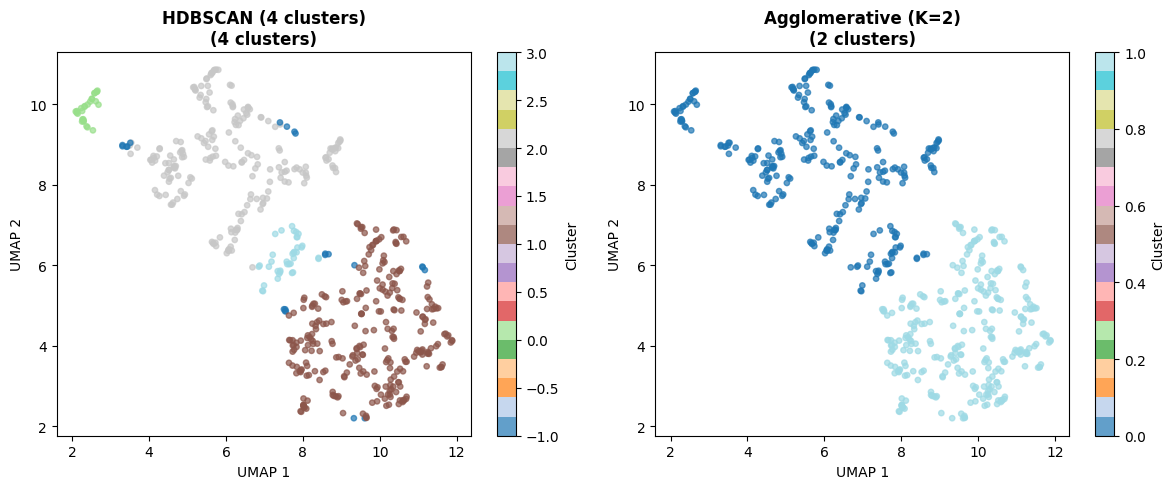


✅ ANALYSE TERMINÉE

📊 RÉSUMÉ:
   • HDBSCAN optimal: 4 clusters
   • Agglomerative optimal: 2 clusters
   • Suggestion dendrogram: 572 clusters

💡 RECOMMANDATION:
   Utilisez l'Agglomerative Clustering avec K=2
   pour une découverte plus contrôlée des sous-stades NREM.


In [3]:
"""
NREM Substages Discovery - VERSION OPTIMISÉE
Objectif: Découvrir 4-7 sous-stades (pas seulement 2!)
Améliorations: UMAP optimisé + critère de sélection mixte + dendrogram
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap
import hdbscan
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings("ignore")

# Configuration globale
FS = 500
WINDOW_SEC = 5
STEP_SEC = 2.5
NFFT = 2048

BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'sigma': (12, 15),
    'beta': (15, 30),
    'gamma': (30, 80)
}

# ============================================================================
# PART 1: FEATURE EXTRACTION
# ============================================================================

def window_dataframe(df, fs=FS, window_sec=WINDOW_SEC, step_sec=STEP_SEC):
    win_len = int(window_sec * fs)
    step = int(step_sec * fs)
    n = len(df)
    windows = []
    starts = []
    ends = []
    for start in range(0, n - win_len + 1, step):
        end = start + win_len
        windows.append(df.iloc[start:end])
        starts.append(start)
        ends.append(end)
    return windows, np.array(starts), np.array(ends)


def band_power_from_psd(freqs, psd, fmin, fmax):
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    if np.sum(idx) == 0:
        return 0.0
    return np.trapezoid(psd[idx], freqs[idx])


def extract_features_from_window(win_df, fs=FS, nfft=NFFT, bands=BANDS):
    h = win_df['hpc_500'].values
    p = win_df['pfc_500'].values
    feats = {}

    for label, sig in [('hpc', h), ('pfc', p)]:
        feats[f'{label}_rms'] = np.sqrt(np.mean(sig**2))
        feats[f'{label}_var'] = np.var(sig)
        feats[f'{label}_skew'] = float(skew(sig))
        feats[f'{label}_kurt'] = float(kurtosis(sig))
        feats[f'{label}_zcr'] = float(np.mean(np.abs(np.diff(np.sign(sig)))>0))

        freqs, psd = welch(sig, fs=fs, nperseg=min(len(sig), 512), nfft=nfft)
        total_power = np.trapz(psd, freqs) + 1e-12
        feats[f'{label}_total_power'] = total_power

        for band_name, (fmin, fmax) in bands.items():
            feats[f'{label}_bp_{band_name}'] = band_power_from_psd(freqs, psd, fmin, fmax)
            feats[f'{label}_bp_{band_name}_rel'] = feats[f'{label}_bp_{band_name}'] / total_power

    feats['cross_corr'] = float(np.corrcoef(h, p)[0,1])

    for label in ['hpc', 'pfc']:
        delta = feats[f'{label}_bp_delta']
        theta = feats[f'{label}_bp_theta']
        feats[f'{label}_delta_theta'] = delta / (theta + 1e-12)
        feats[f'{label}_delta_beta'] = delta / (feats[f'{label}_bp_beta'] + 1e-12)

    return feats


def build_feature_matrix(df_nrem, verbose=True):
    if verbose:
        print('🔄 Fenêtrage et extraction de features...')
    windows, starts, ends = window_dataframe(df_nrem, fs=FS, window_sec=WINDOW_SEC, step_sec=STEP_SEC)
    features = []
    for i, win in enumerate(windows):
        feats = extract_features_from_window(win, fs=FS)
        feats['window_idx'] = i
        feats['start_sample'] = starts[i]
        feats['end_sample'] = ends[i]
        features.append(feats)
        if verbose and i % 500 == 0 and i > 0:
            print(f"  → {i}/{len(windows)} fenêtres")

    features_df = pd.DataFrame(features)
    if verbose:
        print(f'✓ Matrice de features: {features_df.shape}')
    return features_df


# ============================================================================
# PART 2: PRE-TREATMENT AND OPTIMIZED DIMENSIONAL REDUCTION
# ============================================================================

def preprocess_features(features_df, n_components_pca=15):
    """Augmentation de 10 à 15 composantes PCA pour plus de détails"""
    meta_cols = ['window_idx', 'start_sample', 'end_sample']
    feat_cols = [c for c in features_df.columns if c not in meta_cols]

    X = features_df[feat_cols].fillna(0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=n_components_pca, random_state=42)
    X_pca = pca.fit_transform(Xs)

    print(f'✓ PCA: {n_components_pca} composantes, variance expliquée: {pca.explained_variance_ratio_.sum():.2%}')

    return Xs, X_pca, feat_cols, scaler, pca


def compute_umap_embedding(Xs, n_neighbors=5, min_dist=0.0):
    """
    UMAP optimisé pour capturer les PETITES structures
    - n_neighbors=5 (au lieu de 15) : focus sur les voisins proches
    - min_dist=0.0 : permet des clusters plus compacts
    """
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42,
        metric='euclidean'
    )
    X_emb = reducer.fit_transform(Xs)
    print(f'✓ UMAP 2D calculé (n_neighbors={n_neighbors}, min_dist={min_dist})')
    return X_emb, reducer


# ============================================================================
# PART 3: CLUSTERING WITH MIXED CRITERIA (quality + number)
# ============================================================================

def compute_clustering_metrics(X, labels):
    """Calcule les métriques de qualité du clustering"""
    valid_labels = labels[labels != -1]
    X_valid = X[labels != -1]

    if len(np.unique(valid_labels)) < 2:
        return None

    metrics = {
        'n_clusters': len(np.unique(valid_labels)),
        'n_noise': np.sum(labels == -1),
        'noise_ratio': np.sum(labels == -1) / len(labels),
        'silhouette': silhouette_score(X_valid, valid_labels),
        'davies_bouldin': davies_bouldin_score(X_valid, valid_labels),
        'calinski_harabasz': calinski_harabasz_score(X_valid, valid_labels)
    }
    return metrics


def compute_mixed_score(metrics, target_clusters=5):
    """
    Score mixte qui favorise:
    - Bon Silhouette (qualité)
    - Nombre de clusters proche de target_clusters
    - Bruit modéré (< 40%)
    """
    if metrics['noise_ratio'] > 0.5:  # Trop de bruit
        return -1

    # Pénalité distance au nombre cible
    cluster_penalty = abs(metrics['n_clusters'] - target_clusters) / target_clusters

    # Score composite (plus c'est haut, mieux c'est)
    score = metrics['silhouette'] * (1 - cluster_penalty) * (1 - metrics['noise_ratio'])

    return score


def test_hdbscan_parameters(X_emb, param_grid, target_clusters=5):
    """Teste plusieurs configurations HDBSCAN avec critère mixte"""
    print("\n" + "="*70)
    print(f"🔍 TEST HDBSCAN (Cible: {target_clusters} clusters)")
    print("="*70)

    results = []

    for min_cluster_size in param_grid['min_cluster_size']:
        for min_samples in param_grid['min_samples']:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                cluster_selection_method='eom'
            )
            labels = clusterer.fit_predict(X_emb)

            metrics = compute_clustering_metrics(X_emb, labels)
            if metrics is not None:
                metrics['min_cluster_size'] = min_cluster_size
                metrics['min_samples'] = min_samples
                metrics['mixed_score'] = compute_mixed_score(metrics, target_clusters)
                results.append(metrics)

                print(f"min_size={min_cluster_size:2d}, min_samples={min_samples:2d} → "
                      f"K={metrics['n_clusters']:2d}, "
                      f"Bruit={metrics['noise_ratio']:.1%}, "
                      f"Sil={metrics['silhouette']:.3f}, "
                      f"Score={metrics['mixed_score']:.3f}")

    if not results:
        print("⚠ Aucune configuration valide")
        return None, None, None

    df_results = pd.DataFrame(results)

    # Sélection du meilleur selon le score mixte
    best_idx = df_results['mixed_score'].idxmax()
    best_params = df_results.loc[best_idx]

    print("\n" + "-"*70)
    print("🏆 MEILLEURE CONFIGURATION (Score Mixte):")
    print(f"   min_cluster_size = {int(best_params['min_cluster_size'])}")
    print(f"   min_samples = {int(best_params['min_samples'])}")
    print(f"   → Clusters: {int(best_params['n_clusters'])}")
    print(f"   → Silhouette: {best_params['silhouette']:.4f}")
    print(f"   → Bruit: {best_params['noise_ratio']:.1%}")
    print(f"   → Score Mixte: {best_params['mixed_score']:.4f}")
    print("-"*70)

    return best_params, df_results, results


def run_final_hdbscan(X_emb, min_cluster_size, min_samples):
    """Exécute HDBSCAN avec les paramètres optimaux"""
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(min_cluster_size),
        min_samples=int(min_samples),
        cluster_selection_method='eom',
        prediction_data=True
    )
    labels = clusterer.fit_predict(X_emb)
    return labels, clusterer


# ============================================================================
# PART 4: HIERARCHICAL ANALYSIS (DENDROGRAM)
# ============================================================================

def plot_hierarchical_dendrogram(X_emb, max_d=None):
    """
    Visualise le dendrogram pour comprendre la structure hiérarchique
    Aide à décider du nombre naturel de clusters
    """
    print("\n" + "="*70)
    print("🌲 ANALYSE HIÉRARCHIQUE (Dendrogram)")
    print("="*70)

    # Calcul du linkage
    linkage_matrix = linkage(X_emb, method='ward')

    # Visualisation
    plt.figure(figsize=(14, 6))

    # Dendrogram complet
    plt.subplot(1, 2, 1)
    dendrogram(linkage_matrix, no_labels=True, color_threshold=0)
    plt.title('Dendrogram Complet', fontsize=12, fontweight='bold')
    plt.xlabel('Échantillons')
    plt.ylabel('Distance')
    plt.axhline(y=linkage_matrix[-5, 2], color='r', linestyle='--', label='Coupe 6 clusters')
    plt.axhline(y=linkage_matrix[-4, 2], color='orange', linestyle='--', label='Coupe 5 clusters')
    plt.axhline(y=linkage_matrix[-3, 2], color='g', linestyle='--', label='Coupe 4 clusters')
    plt.legend()

    # Dendrogram tronqué (top 20 fusions)
    plt.subplot(1, 2, 2)
    dendrogram(linkage_matrix, truncate_mode='lastp', p=20, show_leaf_counts=True)
    plt.title('Dendrogram Tronqué (20 dernières fusions)', fontsize=12, fontweight='bold')
    plt.xlabel('Nombre d\'échantillons dans les nœuds')
    plt.ylabel('Distance')

    plt.tight_layout()
    plt.show()

    # Suggestion du nombre de clusters
    distances = linkage_matrix[-10:, 2]
    diff_distances = np.diff(distances)
    optimal_idx = np.argmax(diff_distances)
    optimal_k = len(linkage_matrix) - optimal_idx + 1

    print(f"\n💡 Suggestion d'après le dendrogram: {optimal_k} clusters")
    print("   (basé sur le plus grand saut de distance)")

    return linkage_matrix, optimal_k


def test_agglomerative_clustering(X_emb, k_range=range(2, 11)):
    """
    Teste Agglomerative Clustering pour différentes valeurs de K
    et affiche les métriques
    """
    print("\n" + "="*70)
    print("🔬 TEST AGGLOMERATIVE CLUSTERING (K variable)")
    print("="*70)

    results = []

    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = agg.fit_predict(X_emb)

        metrics = compute_clustering_metrics(X_emb, labels)
        if metrics:
            metrics['k'] = k
            results.append(metrics)
            print(f"K={k:2d} → Sil={metrics['silhouette']:.3f}, DB={metrics['davies_bouldin']:.3f}")

    df_agg = pd.DataFrame(results)

    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(df_agg['k'], df_agg['silhouette'], 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Nombre de Clusters (K)')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title('Silhouette vs K')
    axes[0].grid(alpha=0.3)

    axes[1].plot(df_agg['k'], df_agg['davies_bouldin'], 'o-', color='orange', linewidth=2, markersize=8)
    axes[1].set_xlabel('Nombre de Clusters (K)')
    axes[1].set_ylabel('Davies-Bouldin Index')
    axes[1].set_title('Davies-Bouldin vs K (plus bas = mieux)')
    axes[1].grid(alpha=0.3)

    axes[2].plot(df_agg['k'], df_agg['calinski_harabasz'], 'o-', color='green', linewidth=2, markersize=8)
    axes[2].set_xlabel('Nombre de Clusters (K)')
    axes[2].set_ylabel('Calinski-Harabasz Score')
    axes[2].set_title('Calinski-Harabasz vs K (plus haut = mieux)')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Meilleur K selon Silhouette
    best_k = df_agg.loc[df_agg['silhouette'].idxmax(), 'k']
    print(f"\n🏆 Meilleur K (Silhouette): {int(best_k)}")

    return df_agg, int(best_k)


# ============================================================================
# PARTIE 5: VISUALIZATION
# ============================================================================

def plot_clustering_results(X_emb, labels, title="Clustering NREM"):
    """Visualise les résultats du clustering sur UMAP"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels != -1])

    scatter = ax.scatter(X_emb[:, 0], X_emb[:, 1], c=labels, s=20, cmap='tab20', alpha=0.7)
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(f'{title}\n{n_clusters} sous-stades détectés', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Cluster ID')
    plt.tight_layout()
    plt.show()


def plot_multiple_clustering_comparison(X_emb, labels_dict):
    """Compare visuellement plusieurs résultats de clustering"""
    n_methods = len(labels_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))

    if n_methods == 1:
        axes = [axes]

    for idx, (method_name, labels) in enumerate(labels_dict.items()):
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels[unique_labels != -1])

        scatter = axes[idx].scatter(X_emb[:, 0], X_emb[:, 1], c=labels, s=15, cmap='tab20', alpha=0.7)
        axes[idx].set_xlabel('UMAP 1')
        axes[idx].set_ylabel('UMAP 2')
        axes[idx].set_title(f'{method_name}\n({n_clusters} clusters)', fontweight='bold')
        plt.colorbar(scatter, ax=axes[idx], label='Cluster')

    plt.tight_layout()
    plt.show()


# ============================================================================
# PRINCIPAL PIPELINE
# ============================================================================

def run_nrem_analysis_optimized(df_nrem):
    print("\n" + "="*70)
    print("🧠 ANALYSE NREM OPTIMISÉE (Version Granulaire)")
    print("="*70)
    print(f"Données: {len(df_nrem):,} échantillons ({len(df_nrem)/500/60:.1f} min)")

    # 1. Extraction de features
    features_df = build_feature_matrix(df_nrem, verbose=True)

    # 2. Prétraitement (15 composantes PCA au lieu de 10)
    Xs, X_pca, feat_cols, scaler, pca = preprocess_features(features_df, n_components_pca=15)

    # 3. UMAP optimisé (n_neighbors=5 pour petites structures)
    X_emb, reducer = compute_umap_embedding(Xs, n_neighbors=5, min_dist=0.0)

    # 4. Analyse hiérarchique (dendrogram)
    linkage_matrix, suggested_k = plot_hierarchical_dendrogram(X_emb)

    # 5. Test Agglomerative pour K=2 à 10
    df_agg_results, best_k_agg = test_agglomerative_clustering(X_emb, k_range=range(2, 11))

    # 6. Grid search HDBSCAN avec critère mixte
    param_grid = {
        'min_cluster_size': [3, 5, 7, 10, 15, 20, 30],
        'min_samples': [1, 2, 3, 5, 7, 10]
    }
    best_params, df_hdb_results, _ = test_hdbscan_parameters(X_emb, param_grid, target_clusters=5)

    if best_params is None:
        print("❌ Échec du clustering HDBSCAN")
        return None

    # 7. Clustering final HDBSCAN
    labels_hdbscan, clusterer = run_final_hdbscan(
        X_emb,
        best_params['min_cluster_size'],
        best_params['min_samples']
    )

    # 8. Clustering final Agglomerative (avec K optimal)
    agg_optimal = AgglomerativeClustering(n_clusters=best_k_agg, linkage='ward')
    labels_agg = agg_optimal.fit_predict(X_emb)

    # 9. Comparaison visuelle
    plot_multiple_clustering_comparison(X_emb, {
        f'HDBSCAN ({int(best_params["n_clusters"])} clusters)': labels_hdbscan,
        f'Agglomerative (K={best_k_agg})': labels_agg
    })

    print("\n" + "="*70)
    print("✅ ANALYSE TERMINÉE")
    print("="*70)
    print(f"\n📊 RÉSUMÉ:")
    print(f"   • HDBSCAN optimal: {int(best_params['n_clusters'])} clusters")
    print(f"   • Agglomerative optimal: {best_k_agg} clusters")
    print(f"   • Suggestion dendrogram: {suggested_k} clusters")

    return {
        'features_df': features_df,
        'X_emb': X_emb,
        'labels_hdbscan': labels_hdbscan,
        'labels_agg': labels_agg,
        'best_params_hdb': best_params,
        'best_k_agg': best_k_agg,
        'suggested_k': suggested_k
    }


# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Chargement des données NREM
    df = pd.read_csv("dataset_predicted.csv")
    df_nrem = df[df['predicted_state'] == 3].reset_index(drop=True)

    # Lancement de l'analyse optimisée
    results = run_nrem_analysis_optimized(df_nrem)

    if results:
        print("\n💡 RECOMMANDATION:")
        print(f"   Utilisez l'Agglomerative Clustering avec K={results['best_k_agg']}")
        print(f"   pour une découverte plus contrôlée des sous-stades NREM.")